## Exploring Canadian Mortality Tables

For my master thesis I developed a model of the Canadian population that included births, immigration, and mortality. My goal was to recreate the projection used by the government so I could analyze how demographic changes impact the Canadian Pension Plan. My model used life tables to calculate mortality each year. While the government publishes historic life tables going back to 1921, they don't publish life tables for their projections. Instead, they simply publish their final life expectancy figure for each year. For example, life expectancy for males at birth in 2075 is projected to be 86. 

The goal of this project is to write a function that will take historic life tables, a list of years and life expectancies and: 
1. Create a series of life tables that match the projections published by the government of Canada. 
2. Project the trend in life expectancies forward until 2120

First, lets briefly explore historic life expectancies in Canada. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import style
from scipy.interpolate import interp1d

In [2]:
#Define our plot style
plt.style.use('seaborn-whitegrid')

#Set defaults for matplotlib
plt.rcParams['figure.figsize'] = [18.0, 10.0]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.size'] = 20
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams['figure.titlesize'] = 'large'
plt.rcParams['lines.linewidth'] = 3

In [3]:
def max_years_lived():
    """The oldest someone can live in a lifetable"""
    return 110

def create_years(first_year, last_year):
    """Creates a list of years"""
    return np.linspace(first_year, last_year, last_year-first_year+1).astype(int)

In [4]:
def import_mortality_tables(url):
    """Imports and formats mortality data from the Canadian Mortality Database"""
    
    mortality_tables = pd.read_csv(url, sep=' ', skiprows=2, skipinitialspace=True)
    
    columns = ['Year', 'Age', 'qx','ex']
    #In the 'Age' column, I need to replace '110+' with '110'
    mortality_tables.Age.replace('110+', 110, inplace=True)
    
    return mortality_tables[columns].apply(pd.to_numeric)

In [5]:
#Define the dataframes
life_table_male = import_mortality_tables('http://www.prdh.umontreal.ca/BDLC/data/can/mltper_1x1.txt')
life_table_female = import_mortality_tables('http://www.prdh.umontreal.ca/BDLC/data/can/fltper_1x1.txt')

In [6]:
#Data Inspection
life_table_male.head()

,Year,Age,qx,ex
0,1921,0,0.12724,55.95
1,1921,1,0.01765,63.06
2,1921,2,0.00848,63.19
3,1921,3,0.00609,62.72
4,1921,4,0.00473,62.11


[]

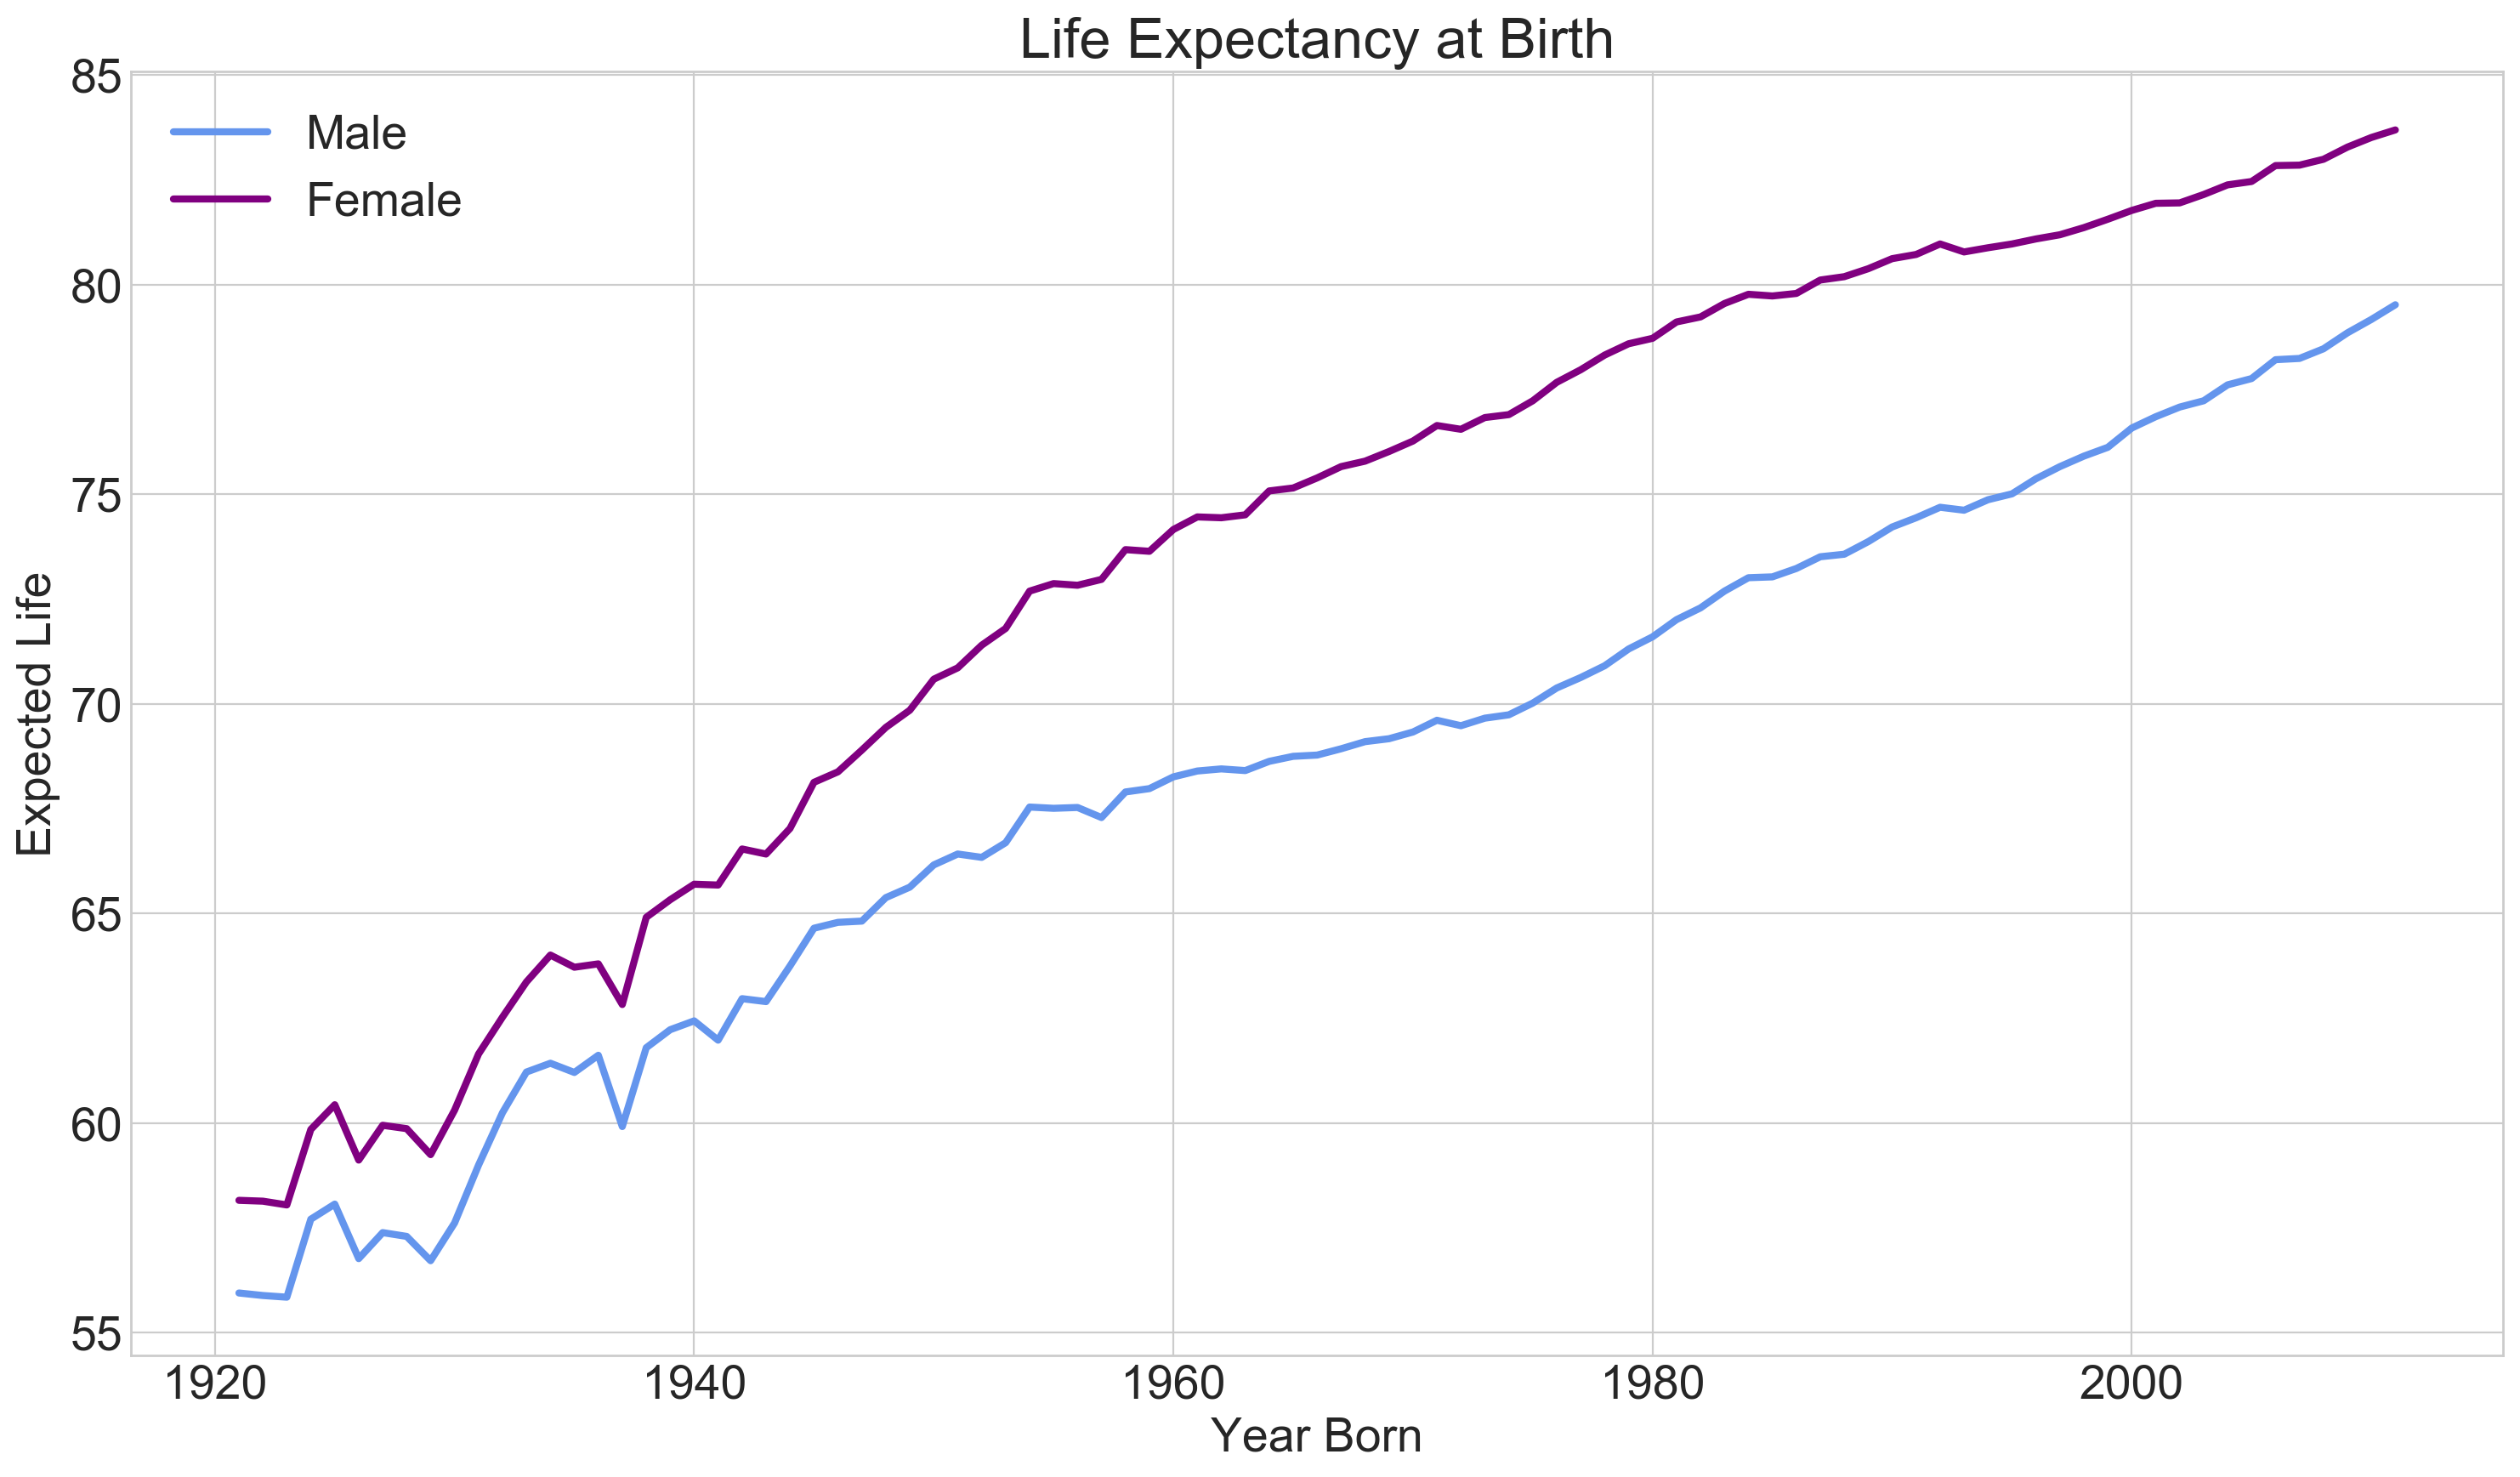

In [7]:
plt.plot(life_table_male[life_table_male.Age==0].set_index('Year')['ex'],\
         label = 'Male', color='cornflowerblue')
plt.plot(life_table_female[life_table_female.Age==0].set_index('Year')['ex'], \
         label = 'Female', color='purple')
plt.title('Life Expectancy at Birth')
plt.ylabel('Expected Life')
plt.xlabel('Year Born')
plt.legend()
plt.plot()

This graph shows the life expectancy at birth for Canadian males and females from 1921. Life expectancy has increased for both male and female by over 20 years since the 1921, but not smoothly. In fact we see quite a bit of variation before the end of WW2 in 1945. Similar to other countries, females tend to live longer than men, and this has been the case in Canada. Although there appears that gap between male and female life expectancy widened in the 1960s, and then started to narrow after 1980.

Next, lets graph the difference between male and female life expectancy. 

[]

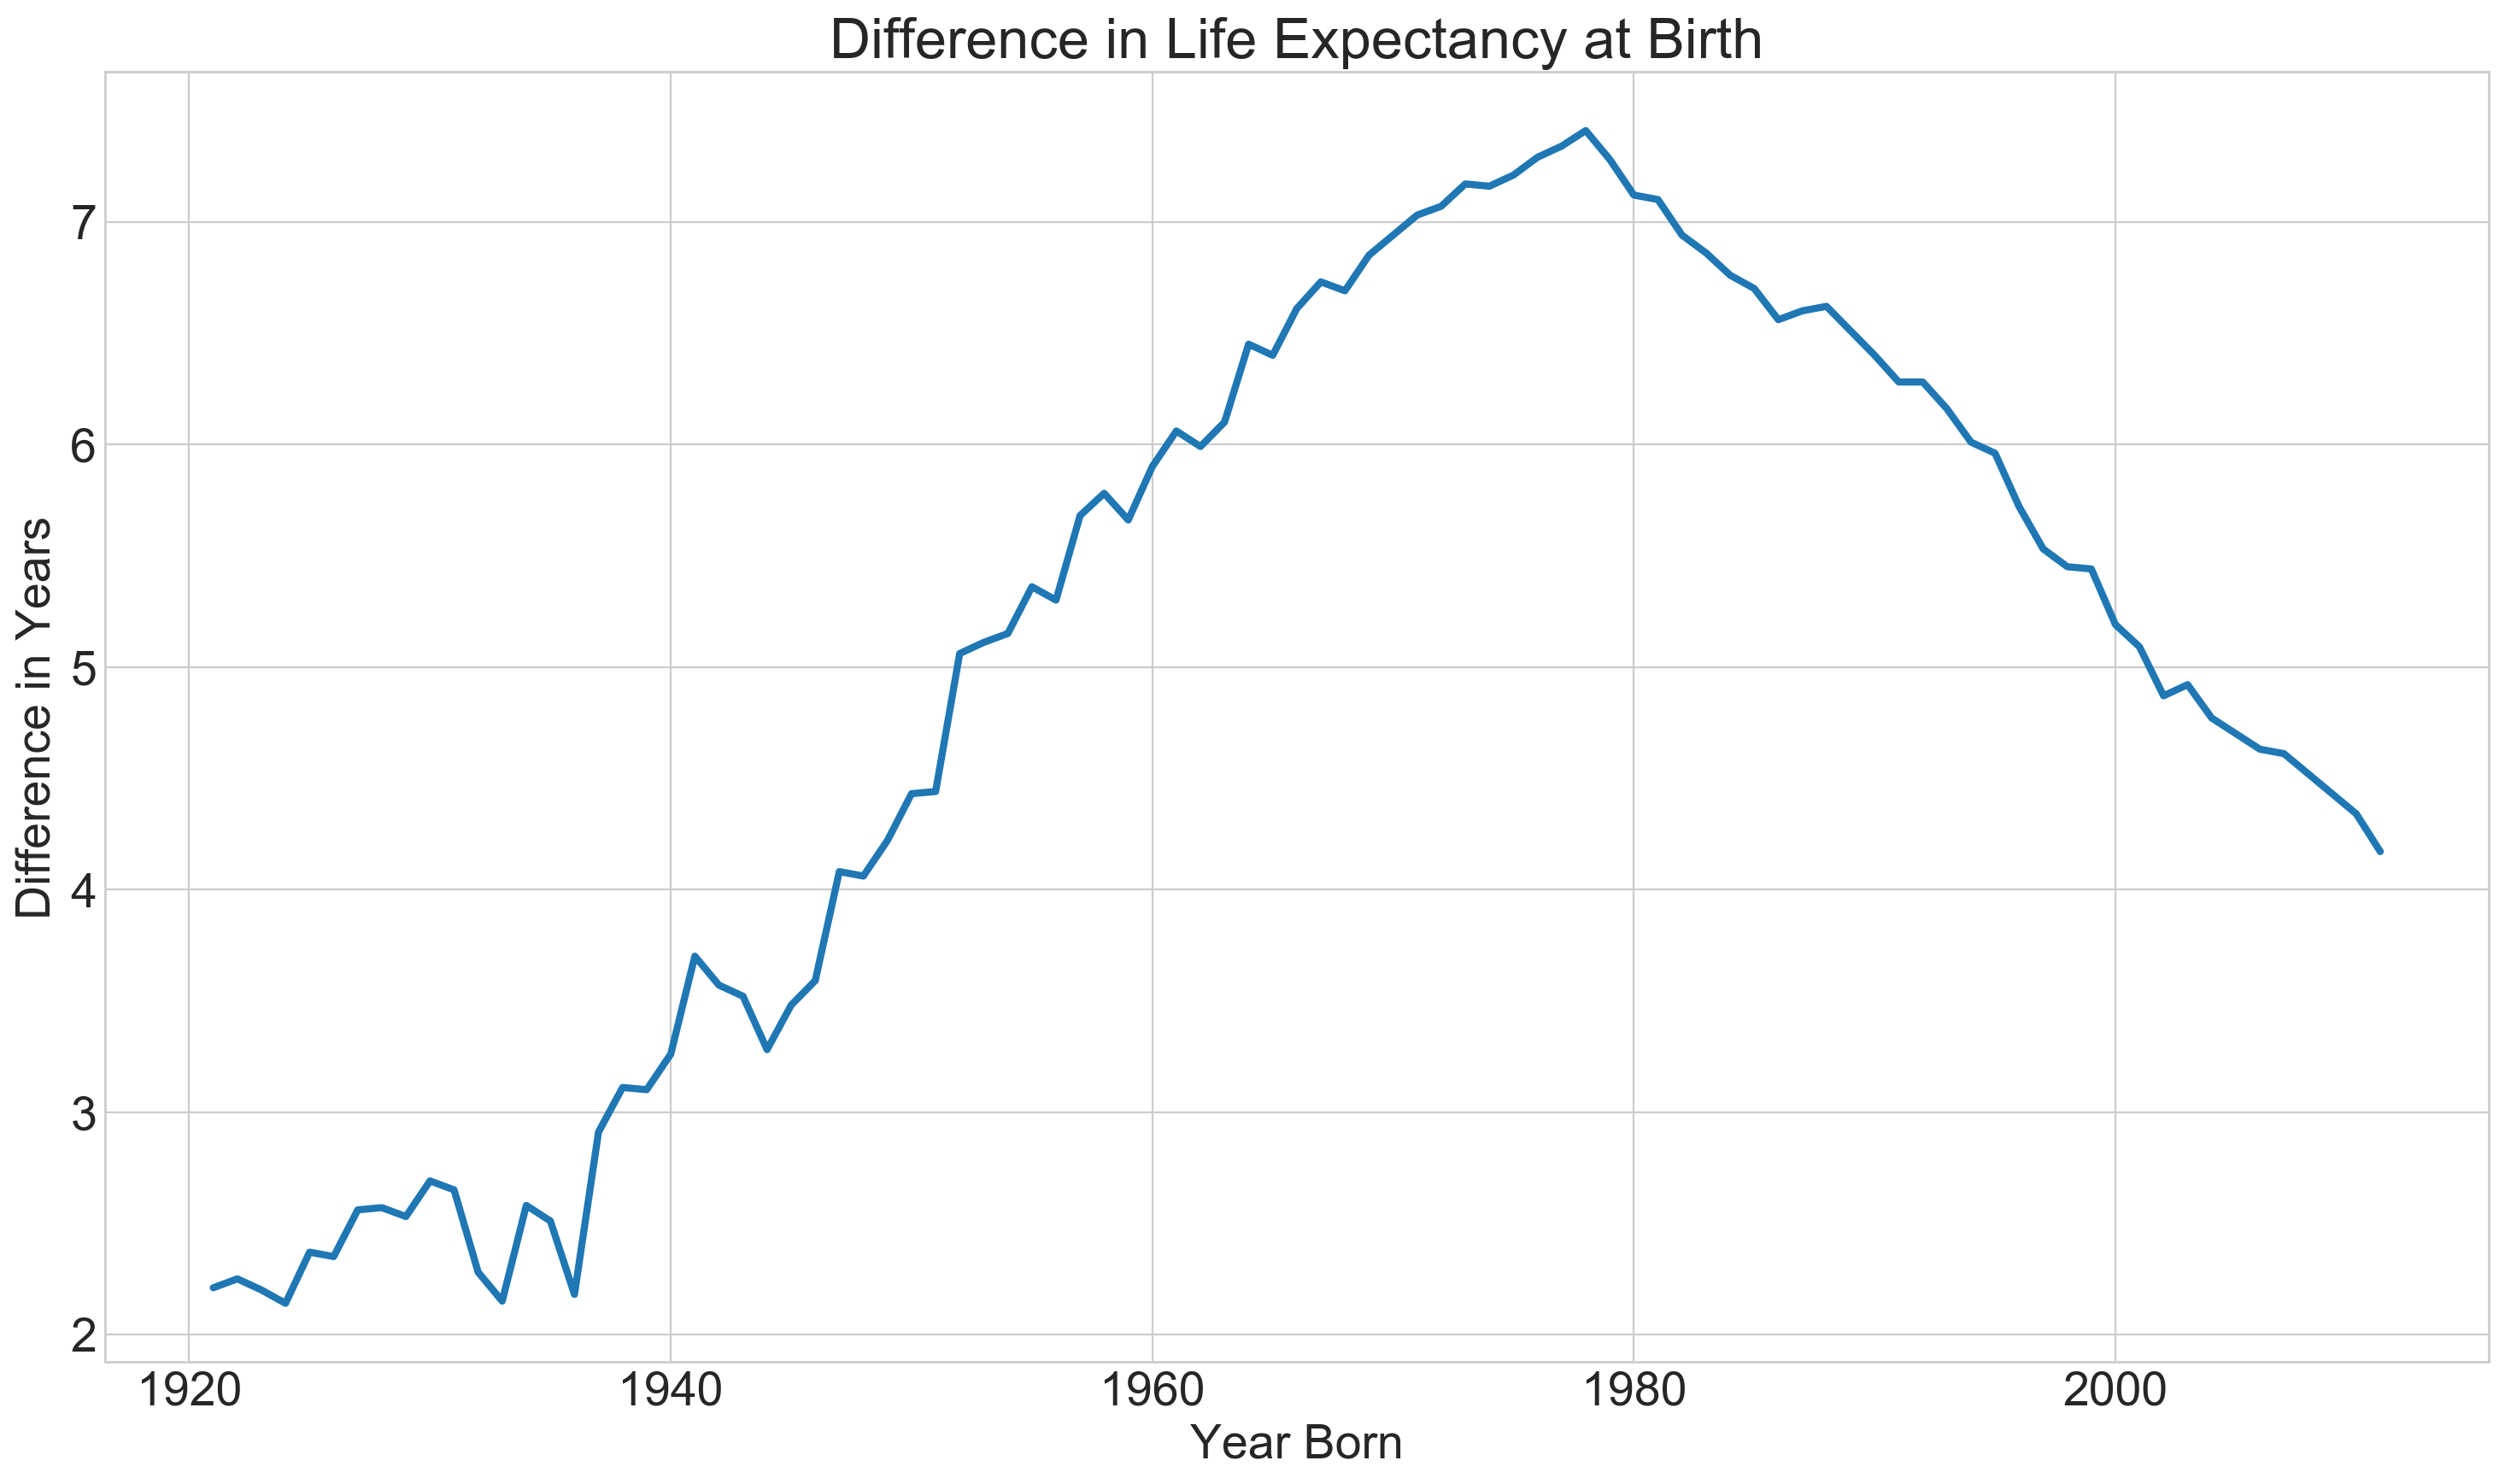

In [9]:
difference = life_table_female[life_table_female.Age==0].set_index('Year')['ex'] \
- life_table_male[life_table_male.Age==0].set_index('Year')['ex']

plt.plot(difference)
plt.title('Difference in Life Expectancy at Birth')
plt.ylabel('Difference in Years')
plt.xlabel('Year Born')
plt.plot()

The difference between male and female life expectancy has changed a lot over the years. In the 1920s there was only a 2 year difference between females and males, but by the mid 1960s it was over 7 years. But this difference is indeed closing. 

### Projecting Mortality

In 1981 [Lee-Carter developed a statistical method of forecasting mortality](https://en.wikipedia.org/wiki/Lee%E2%80%93Carter_model). The Lee-Carter method summarizes log-mortality rates log $q_{xt}$ along the age dimension using the vectors $a$ and $b$ and along the time dimension with the vector $k$, with the restrictions that the k's sum to zero, and the a's are calculated using average log rates. 

\begin{equation}
log \space q_{xt} = a_x + b_xk_t + e_{xt}
\end{equation}

These parameters can be summarized as such: 
* $a$ represents the average age profile of mortality. It is calculated by averaging log-rates over time. 
* $k$ represents how mortality changes over time calculated using singular value decomposition (SVD) in conjunction with $b$. 
* $b$ determines how each age group changes with $k_t$

Lee-Carter then forecasted $k_t$ using an ARIMA process. Instead, I want to write a function that will take a list of years, and life expectancy figures, and create life tables matching these figures, and project this trend forward. 

I will follow their procedures using Canadian mortality tables. To assist me, I follow the code outlined by using STATA. [German Rodriguez from Princeton University](https://data.princeton.edu/eco572/leecarter) 

In [10]:
def life_table_projection(life_table):
    
    """Calculates the variable 'a', and 'b' for the Lee-Carter method"""

    #Take the log of the 'qx' column
    life_table['log_qx'] = np.log(life_table['qx'])

    #Delete 'qx' column
    del life_table['qx']
    
    #Create a table with 'Age' as rows, and 'Years' as columns
    life_table = life_table.pivot(index='Age', columns='Year', values='log_qx')
    
    #Change the sample years to the most recent 20 years
    life_table = life_table.iloc[:,-20:]

    #Calculate the average 'log_mx' across each 'age'
    life_table['a'] = life_table.mean(axis=1)

    age_groups = len(life_table.index)

    #Subtract the average 'a' in each year from each 'log_mx' value
    for i in range(age_groups):
        life_table.iloc[i,:-1] = life_table.iloc[i,:-1] - life_table.iloc[i].values[-1]
    
    #Save the average into a separate dataframe since we will need it later, then delete it from the main dataframes
    life_table_a = life_table['a']

    #We no longer need the average 'a' columns
    del life_table['a']
    
    u, s, vt = np.linalg.svd(life_table.T, full_matrices=True, compute_uv=True)

    #'b' and 'k' for males
    b = vt[0] / sum(vt[0])
    k = u[:,0]  * sum(vt[0])*s[0]

    #Turn the array into a dataframe
    sample_years = life_table.columns
    k = pd.DataFrame(data = k, index=sample_years, columns = ['K'])
    
    return life_table_a, b

In [11]:
def expected_life(life_table):
    
    """Calculates the life expectancy from a life table"""
    
    a_x = [0.06 if i == 0 else 0.5 for i in range(max_years_lived())]
    a_x[-1] = 1.4
    
    lx = []
    remaining_cohort = [100000]
    
    for i in range(max_years_lived()):
        lx.append(remaining_cohort[-1] - (1-a_x[i])* life_table[i] * remaining_cohort[-1])
        remaining_cohort.append(remaining_cohort[-1] - life_table[i] * remaining_cohort[-1])
        
    return np.round(sum(lx)/100000,2), np.round(sum(lx[65:111])/remaining_cohort[65],2)

In [12]:
def fit_mortality_data_birth(targets, years,  lt_a, lt_b):
    
    """Creates a life table to fit any life expectancy value"""

    k_values = []
    k = -1
    
    for i in range(len(targets)):
        k  = 100
        
        while expected_life(np.exp(lt_a.values + lt_b*k))[0] < targets[i]:
            k += -0.1
            
        if k < -1000:
            break

        k_values.append(k)
    
    return pd.Series(data = k_values,  index = years)

In [13]:
def forecast_mortality_data(k_values):
    
    """Projects a life table based on a series of life expectancy values."""
    
    year = k_values.index.tolist()
    k_values = interp1d(k_values.index, k_values.values, kind='linear')
    years = create_years(year[0], year[-1]) 
    k_values = k_values(years).tolist()
   
    number_of_years = 2120 - years[-1]
    diff = np.mean(np.diff(k_values[-10:]))
    
    #Extend forecast
    for i in range(number_of_years):
        year = years[-1] + i
        k_values.append(k_values[-1]+diff)
        
    return pd.DataFrame(data = k_values, index = create_years(2012, 2120))

In [14]:
def life_tables(a, b, k):
    
    """This transforms the variables into a proper lifetable"""
    
    lt_forecast = []
    total_number_years = 109

    for i in range(total_number_years):
        lt_forecast.append(np.exp(a.values + b*k.values[i]))
   
    lt_forecast = pd.DataFrame(lt_forecast,index=create_years(2012, 2120))    

    return lt_forecast

In [15]:

def life_table_fit(life_table, life_expectancy, year):
    
    """Collects the functions from above into one"""
    
    life_table_copy = life_table.copy()
    a, b = life_table_projection(life_table_copy)
    k = fit_mortality_data_birth(life_expectancy, year, a, b)
    k = forecast_mortality_data(k)
    life_tables(a, b, k)
    return life_tables(a, b, k)

There are many different ways one can model mortality. The Lee-Carter method was chosen for this thesis because it was the simplest to translate into code. This does not mean that its inadequate though. To test its adequacy, I can plug in life expectancy values from the Canadian government for 2016, 2025, and 2050, and then have the model project life expectancy values for 2075. This way I can directly compare how my model of life predicts life expectancy in 2075, to that of the Canadian government.

According to the Canadian government, in 2075, at birth men are expected to live until aged **86**, and once they turn 65, they are expected to live an additional **23.8** years.

In [16]:
#Found in Table 37 found on page 84
#Using data until 2050 to forecast to 2075 for males
expected_life(life_table_fit(life_table_male, [80.7,82.2,84.2],  [2012, 2025, 2050]).loc[2075])

(85.97, 23.49)

The model over estimates life expectancy at births by 0.03 years, and 0.51 years at aged 65. 

Now lets compare the data for women. According to the CPPIB, in 2075, at birth women are expected to live until aged **89**, and once they turn 65, they are expected to live an additional **26** years.

In [18]:
#Found in Table 37 found on page 84
#Using data until 2050 to forecast to 2075 for females
expected_life(life_table_fit(life_table_female,[84.5,85.6,87.4],  [2012, 2025, 2050]).loc[2075])

(88.99, 25.82)

The model under estimates life expectancy at births by 0.01 years, and 0.18 years at aged 65. Overall the model comes very close to recreating the projection by the government. 

Finally, lets project this trend forward until 2020. 

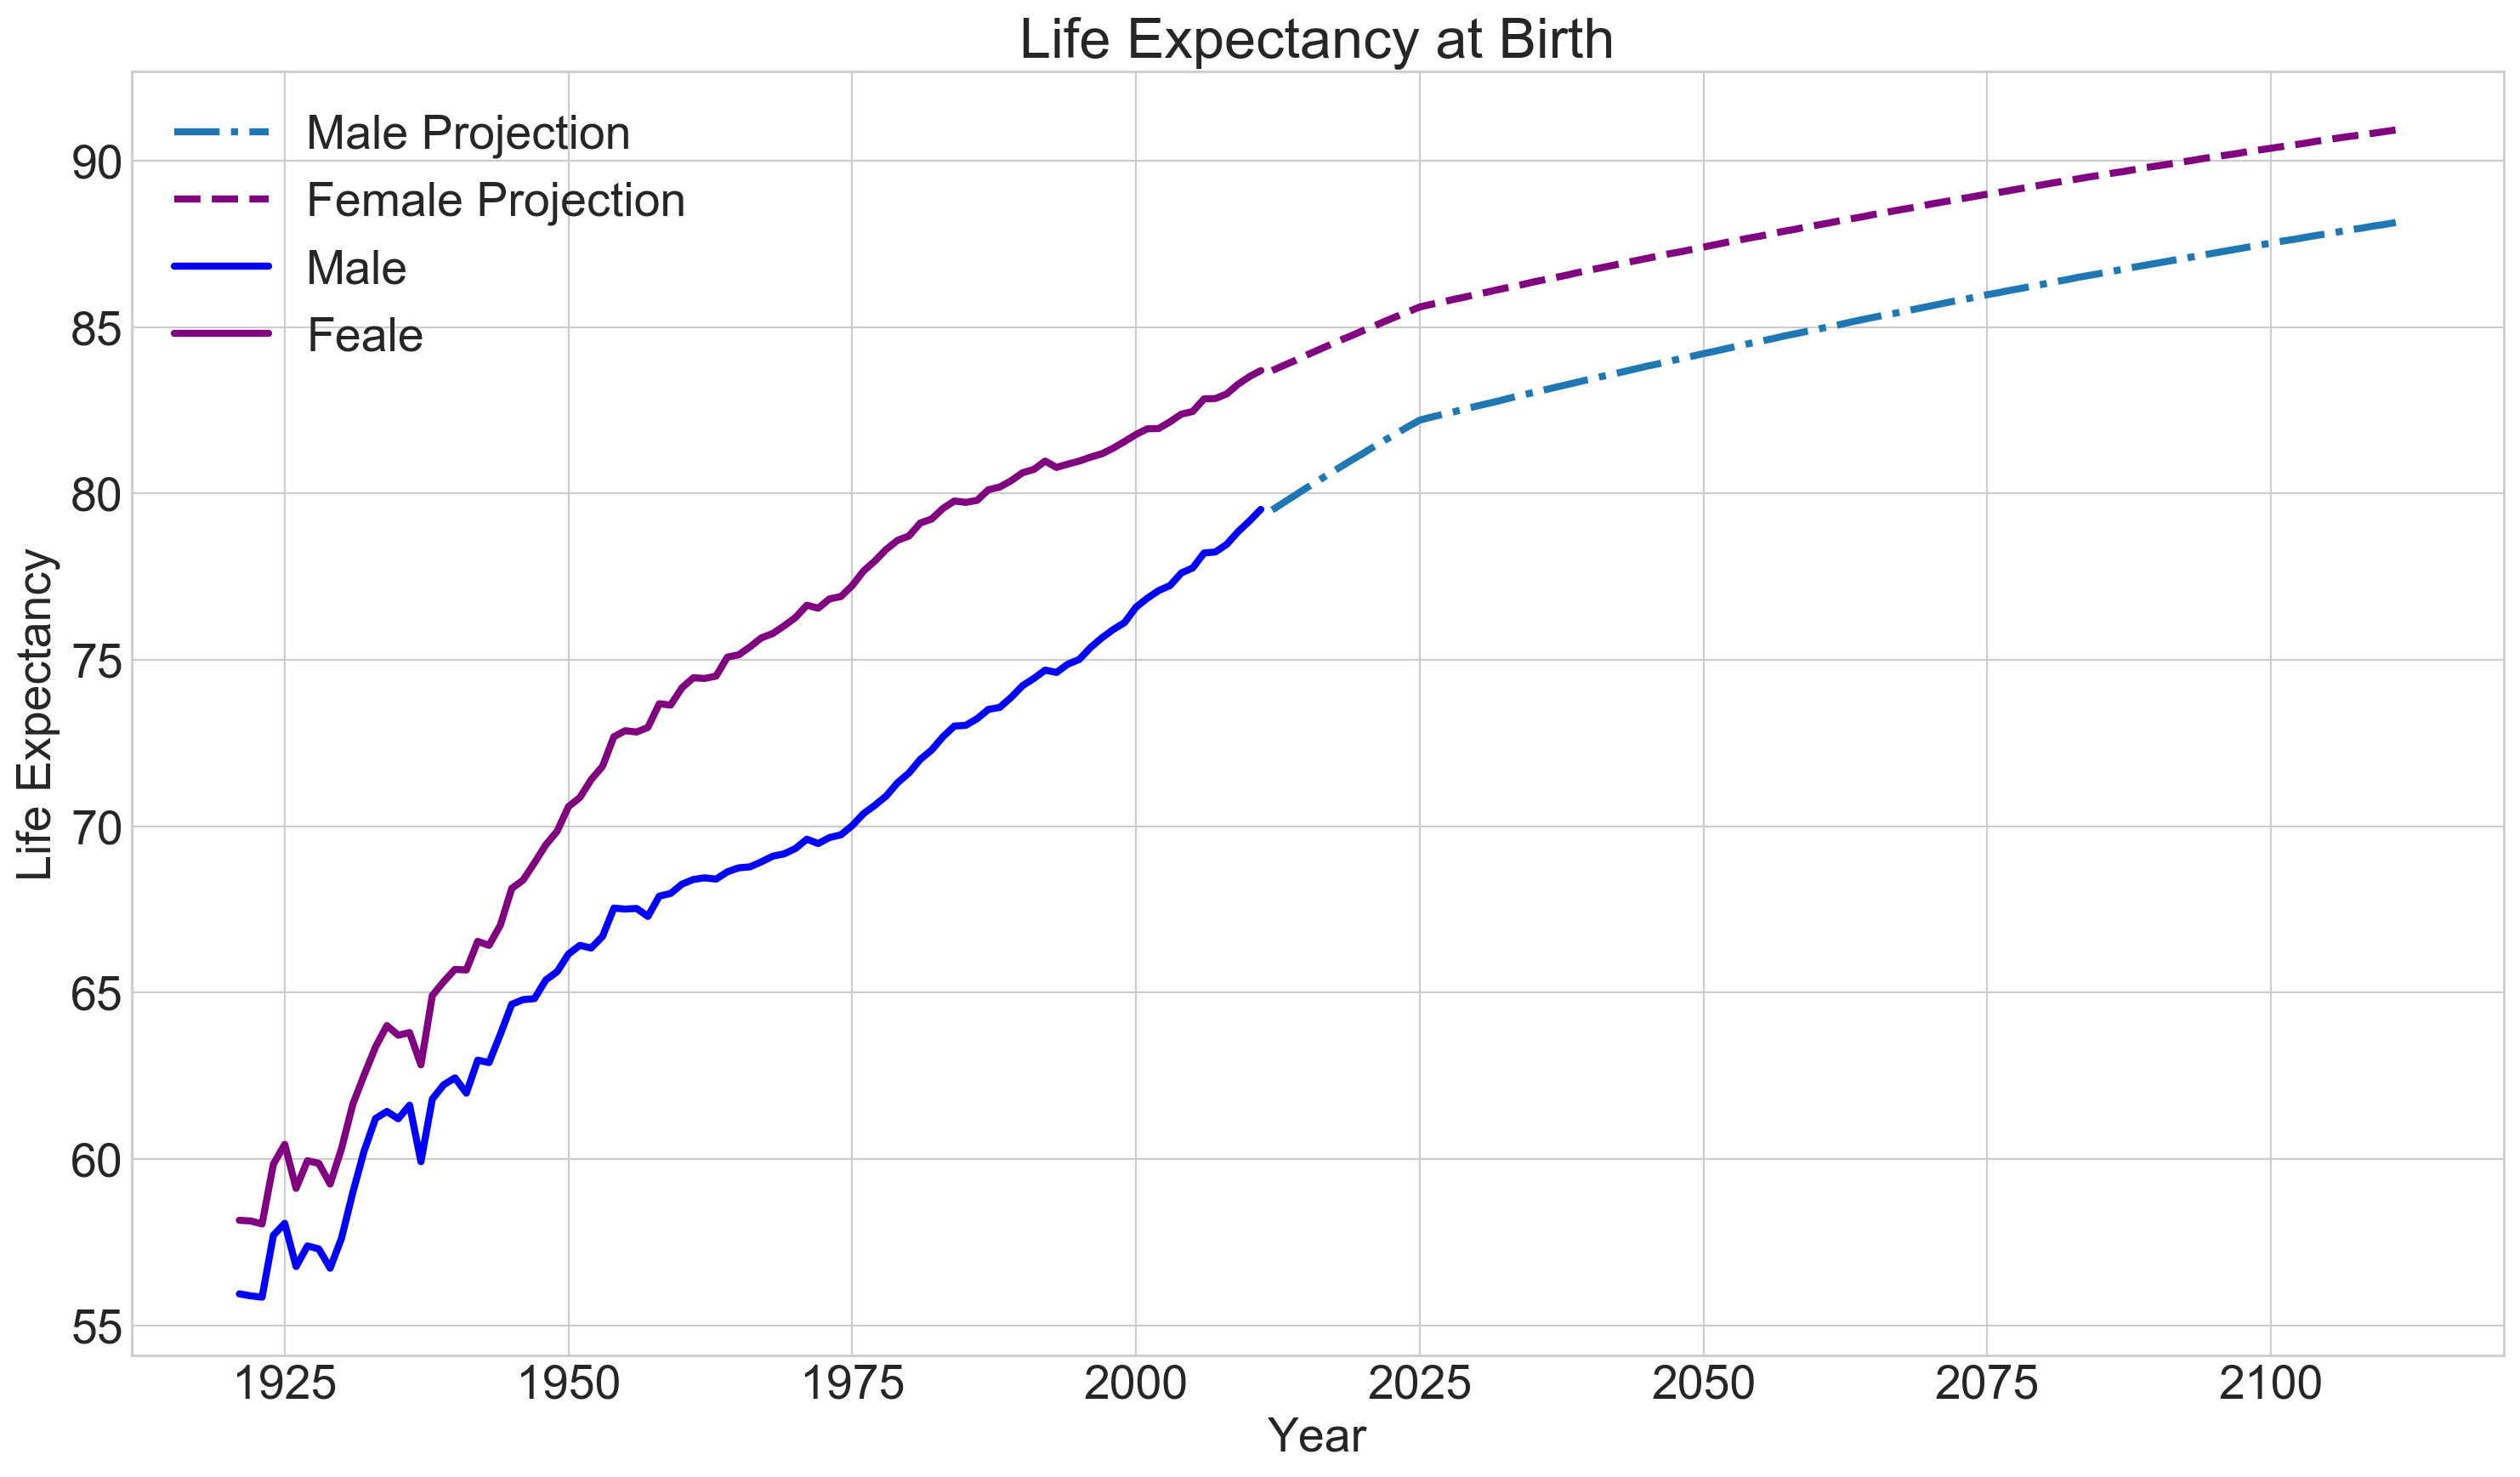

In [19]:
plt.plot(expected_life(life_table_fit(life_table_male, [79.5,82.2,84.2],  [2012, 2025, 2050]))[0][:100], 
         '-.', label= 'Male Projection')
plt.plot(expected_life(life_table_fit(life_table_female, [83.69,85.6,87.4],  [2012, 2025, 2050]))[0][:100], 
         '--',label = 'Female Projection', color = 'purple')
plt.plot(life_table_male[life_table_male.Age==0].set_index('Year')['ex'],color = 'blue',label = 'Male')
plt.plot(life_table_female[life_table_female.Age==0].set_index('Year')['ex'],color = 'purple',label = 'Feale')
plt.legend()
plt.title('Life Expectancy at Birth')
plt.ylabel('Life Expectancy')
plt.xlabel('Year')
plt.show()